The aim of this notebook is to by optimising the position and dwell times of point sources along constrained lines produce a minimum exposure to one cube while producing a maximum exposure to a second cube.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from utilities import BasinhoppingWrapper

Create the voxels

In [2]:
x_ = np.linspace(-1, 1, 21)
y_ = np.linspace(-1, 1, 21)
z_ = np.linspace(-1, 1, 21)

x, y, z = np.meshgrid(x_, y_, z_)
x = np.ravel(x)
y = np.ravel(y)
z = np.ravel(z)

Define the target and avoid cubes

In [3]:
target_cube = (
    (x < 0.5) & (x > -0.5) & 
    (y < 0.5) & (y > -0.5) & 
    (z < 0.5) & (z > -0.5))

avoid_cube = (
    (x < 1) & (x > 0.5) & 
    (y < 0.25) & (y > -0.25) & 
    (z < 0.25) & (z > -0.25))

other = (~target_cube) & (~avoid_cube)

Display the target and avoid cubes

(-1, 1)

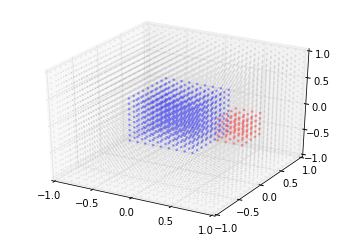

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    x[other], y[other], z[other], 
    alpha=0.1, s=1, color='grey')
ax.scatter(
    x[target_cube], y[target_cube], z[target_cube], 
    alpha=0.3, s=3, color='blue')
ax.scatter(
    x[avoid_cube], y[avoid_cube], z[avoid_cube], 
    alpha=0.3, s=3, color='red')

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

Create initial equidistant parrallel lines with a random skew

In [5]:
line_start = np.meshgrid(
    [-0.3, 0, 0.3],
    [-0.3, 0, 0.3],
    [1])

line_finish = np.array([
    line_start[0] + np.random.normal(scale=0.05, size=[3,3,1]),
    line_start[1] + np.random.normal(scale=0.05, size=[3,3,1]),
    -line_start[2]])

In [6]:
line_start = np.array([np.ravel(mesh) for mesh in line_start])
line_finish = np.array([np.ravel(mesh) for mesh in line_finish])

Display the lines overlayed

(-1, 1)

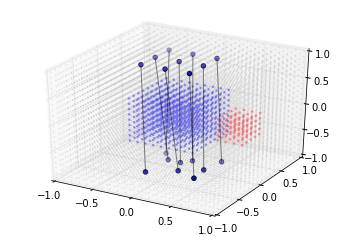

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    x[other], y[other], z[other], 
    alpha=0.1, s=1, color='grey')
ax.scatter(
    x[target_cube], y[target_cube], z[target_cube], 
    alpha=0.3, s=3, color='blue')
ax.scatter(
    x[avoid_cube], y[avoid_cube], z[avoid_cube], 
    alpha=0.3, s=3, color='red')
ax.scatter(*line_start)
ax.scatter(*line_finish)

for i in range(len(line_start[0])):
    plt_coords = [
        [line_start[j][i], line_finish[j][i]]
        for j in range(len(line_start))]
    ax.plot(*plt_coords, color='black', alpha=0.5)

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

Create a function to return x, y, z coords when a distance along a line is requested

In [8]:
diff = (line_finish - line_start)
line_length = np.sqrt(diff[0]**2 + diff[1]**2 + diff[2]**2)

def find_distance_coords(line_num=None, distance=None):
    relative_dist = distance / line_length[line_num]
    
    if (relative_dist > 1) | (relative_dist < 0):
        return np.array([np.nan]*3)
    
    x = (
        line_start[0][line_num] * (1 - relative_dist) + 
        line_finish[0][line_num] * relative_dist)
    
    y = (
        line_start[1][line_num] * (1 - relative_dist) + 
        line_finish[1][line_num] * relative_dist)
        
    z = (
        line_start[2][line_num] * (1 - relative_dist) + 
        line_finish[2][line_num] * relative_dist)
    
    coords = np.array([x, y, z])
    
    return coords

Pick dwell positons 0.1 units apart starting at a random position along the line

In [9]:
dwell_spacing = 0.2
number_of_dwells = np.floor(2 / dwell_spacing).astype(int)

In [10]:
inital_dwell_position = np.random.uniform(low=0, high=dwell_spacing, size=9)
inital_dwell_position

array([ 0.13130068,  0.10337397,  0.18218801,  0.00809303,  0.08980257,
        0.19379102,  0.10494414,  0.04529289,  0.14045165])

In [11]:
def find_dwell_coords(line_num=None, dwell_num=None):
    distance = inital_dwell_position[line_num] + dwell_num * dwell_spacing
    
    coords = find_distance_coords(
        line_num=line_num, distance=distance)
    
    return coords

In [12]:
dwell_positions = np.array([
    [
        find_dwell_coords(
            line_num=line_num, dwell_num=dwell_num)
        for dwell_num in range(number_of_dwells)]
 for line_num in range(9)])

In [13]:
relevant_dwell_positions = np.reshape(dwell_positions, (-1, 3))
keep = (relevant_dwell_positions[:,2] < 0.5) & (relevant_dwell_positions[:,2] > -0.5)
relevant_dwell_positions = relevant_dwell_positions[keep]

Plot the dwell positions

(-1, 1)

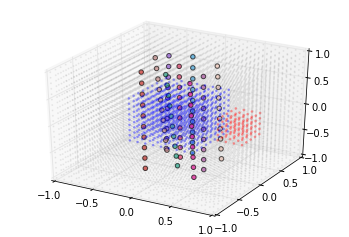

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    x[other], y[other], z[other], 
    alpha=0.1, s=1, color='grey')
ax.scatter(
    x[target_cube], y[target_cube], z[target_cube], 
    alpha=0.3, s=3, color='blue')
ax.scatter(
    x[avoid_cube], y[avoid_cube], z[avoid_cube], 
    alpha=0.3, s=3, color='red')

for line_num in range(9):
    colour = np.random.uniform(size=3)
    ax.scatter(*np.transpose(dwell_positions[line_num]), 
               c=colour, alpha=0.7)


ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

Create an array containing the distance to each dwell position for each voxel and translate this to exposure at that voxel per unit dwell time at each dwell position

In [15]:
distance_to_dwell_pos = np.array([
    np.sqrt(
        (x[i] - relevant_dwell_positions[:,0])**2 + 
        (y[i] - relevant_dwell_positions[:,1])**2 + 
        (z[i] - relevant_dwell_positions[:,2])**2
    )
    for i in range(len(x))
])

exposure_per_unit_time = 1 / distance_to_dwell_pos**2

Run a test of arbitrary dwell times

In [16]:
num_relevant_dwells = len(relevant_dwell_positions)

random_pick = np.random.uniform(size=2, high=num_relevant_dwells, low=0).astype(int)

dwell_times = np.zeros([1, num_relevant_dwells])
dwell_times[0, random_pick] = 10

In [17]:
def calculate_exposure(dwell_times):
    exposure = np.sum(dwell_times * exposure_per_unit_time, axis=1)
    return exposure

In [18]:
exposure = calculate_exposure(dwell_times)

(-1, 1)

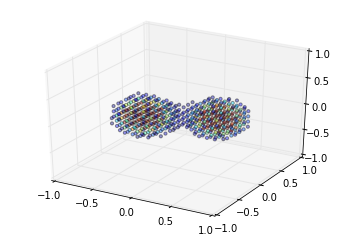

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

reference = exposure > 80
colour = exposure[reference]
colour[colour > 200] = 200

ax.scatter(
    x[reference], y[reference], z[reference], 
    alpha=0.4, s=10, c=colour, cmap=cm.jet)


ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

In [20]:
def display_results(dwell_times):
    dwell_times = np.reshape(dwell_times, (1, num_relevant_dwells))
    exposure = calculate_exposure(dwell_times)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    reference = exposure > 25
    colour = exposure[reference]
    colour[colour > 100] = 100
    
    small = exposure[reference] < 50
    large = ~small

    ax.scatter(
        x[reference][small], y[reference][small], z[reference][small], 
        alpha=0.2, s=3, c=colour[small], cmap=cm.jet)
    
    ax.scatter(
        x[reference][large], y[reference][large], z[reference][large], 
        alpha=0.4, s=20, c=colour[large], cmap=cm.jet)


    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    
    print(cost_function(dwell_times))
    
    plt.show()

Create cost function

In [21]:
min_target_goal = 50
max_avoid_goal = 30

def cost_function(dwell_times):
    dwell_times = np.reshape(dwell_times, (1, num_relevant_dwells))
    exposure = calculate_exposure(dwell_times)
    
    min_target = np.min(exposure[target_cube])
    max_avoid = np.max(exposure[avoid_cube])
    
    squares_threshold = (
        (min_target - min_target_goal)**2 + 
        (max_avoid - max_avoid_goal)**2
    )
    
    return np.sqrt(squares_threshold)

Create initial conditions

In [22]:
initial_conditions = np.ones(num_relevant_dwells)*0.1

Step noise

In [23]:
step_noise = np.ones(num_relevant_dwells) * 1

Bounds

In [24]:
bounds = ((0, None),)*num_relevant_dwells

Run the optimiser

2.86100945155


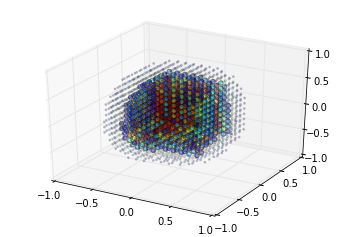

2.96008459045


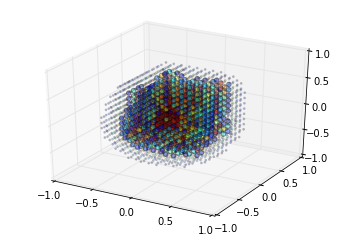

6.11527069616


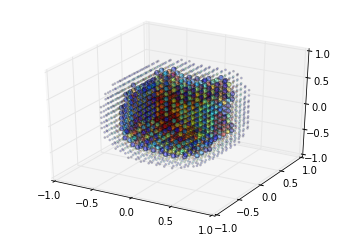

4.03460885906


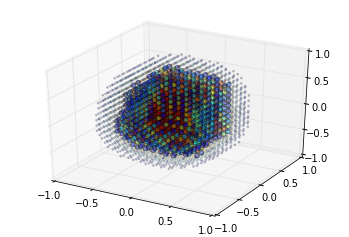

2.40621720529


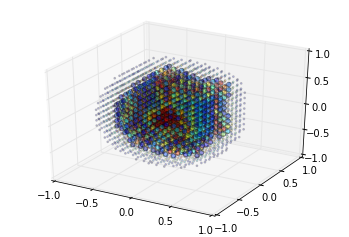

2.54740261533


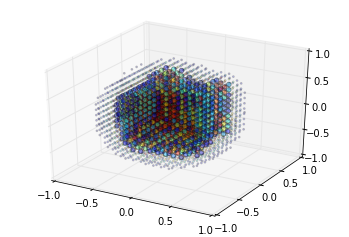

2.12234194279


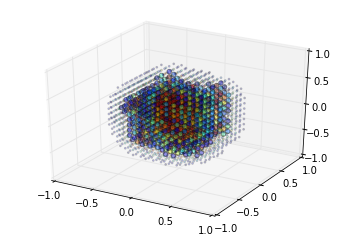

2.62441258177


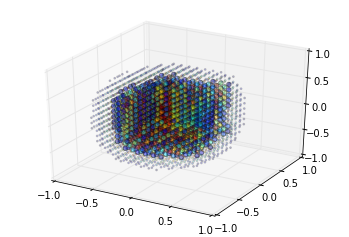

In [25]:
optimisation = BasinhoppingWrapper(
    to_minimise=cost_function,
    initial=initial_conditions,
    step_noise=step_noise,
    confidence=1,
    n=5,
    debug=display_results,
    bounds=bounds
)

2.40621720529


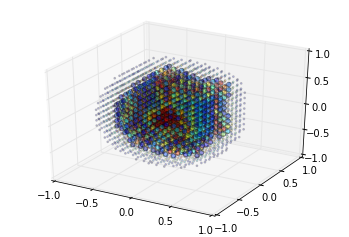

In [30]:
display_results(optimisation.result)

(array([ 25.,   6.,   8.,   3.,   2.,   0.,   0.,   0.,   1.,   1.]),
 array([ 0.        ,  0.2238104 ,  0.44762081,  0.67143121,  0.89524161,
         1.11905202,  1.34286242,  1.56667282,  1.79048323,  2.01429363,
         2.23810403]),
 <a list of 10 Patch objects>)

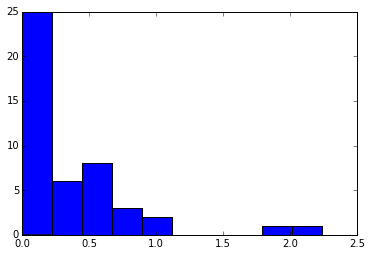

In [26]:
plt.hist(optimisation.result)

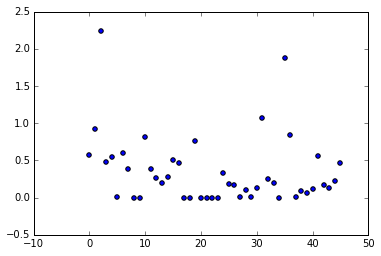

In [29]:
plt.scatter(np.arange(num_relevant_dwells), optimisation.result)